## Synthetic Time Series Evaluation Metrics
<br> **Aim:**
<br> evaluate synthetic data generated for multivariate time-series data
<br> metrics should quantify diversity, fidelity, privacy and utility 
<br>
<br> **Data input:**
<br> **conditional** generation
<br>
<br> **Output:**
<br> metric scores

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from math import pi
import random

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence
# from tsfresh import extract_features
from scipy.linalg import sqrtm
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import spearmanr
from dtaidistance import dtw
from sklearn.neighbors import NearestNeighbors
from scipy.stats import spearmanr
from sklearn.preprocessing import StandardScaler
from scipy.interpolate import interp1d

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\USER\anaconda3\envs\dsi24\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_rows = None
pd.options.display.max_columns = None
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:.2f}'.format

In [3]:
# using py3.8 
print("Python version:", sys.version)

Python version: 3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]


In [4]:
today = datetime.datetime.now().strftime("%Y-%m-%d")
today

'2025-07-31'

### import data

In [5]:
data_dir = 'C:\\Users\\USER\\Documents\\betterdata_task\\data\\TimeSeries\\conditional_generation\\'

#### original data

In [6]:
# check single
filetype = 'original'
filefolder = 'time_series'
filename = 'series_039.csv'

file_path = os.path.join(data_dir, filetype, filefolder, filename)

real_df = pd.read_csv(file_path, index_col=None)

In [7]:
real_df.head(10)

,col1,col2,col3
0,-0.24,0.97,1
1,-0.24,1.00,1
2,-0.24,1.00,1
3,-0.24,0.97,1
4,-0.24,0.93,1
5,-0.24,0.86,1
6,-0.24,0.76,0
7,-0.24,0.65,0
8,-0.24,0.53,0
9,-0.24,0.39,0


In [8]:
real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    95 non-null     float64
 1   col2    95 non-null     float64
 2   col3    95 non-null     int64  
dtypes: float64(2), int64(1)
memory usage: 2.4 KB


In [9]:
real_df.isnull().sum()

col1    0
col2    0
col3    0
dtype: int64

#### static condition for real data

In [10]:
filetype = 'original'
filename = 'static.csv'

file_path = os.path.join(data_dir, filetype, filename)

static_real_df = pd.read_csv(file_path, index_col=None)

In [11]:
static_real_df.head()

,.id,b,k,w1,w2
0,0,0.88,-0.11,0.52,-1.29
1,1,1.31,0.69,0.23,0.28
2,2,0.32,-0.51,-1.24,-0.01
3,3,-0.24,-0.54,-1.30,-1.51
4,4,0.85,0.88,0.76,-0.39


In [12]:
static_real_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   .id     100 non-null    int64  
 1   b       100 non-null    float64
 2   k       100 non-null    float64
 3   w1      100 non-null    float64
 4   w2      100 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 4.0 KB


In [13]:
static_real_df.isnull().sum()

.id    0
b      0
k      0
w1     0
w2     0
dtype: int64

In [14]:
static_real_df['.id'].nunique()

100

In [15]:
static_real_df.columns = static_real_df.columns.str.replace('.', '', regex=False)

NOTE:
- each series in real have diff lengths
- there are 100 unique id in static
- there are 100 series in synthetic

#### synthetic data

In [16]:
# single
# data_dir = 'C:\\Users\\USER\\Documents\\betterdata_task\\data\\TimeSeries\\conditional_generation\\'
synth_type = 'tsv1//'
synth_folder = 'time_series'
filename = 'sample_0.csv'

synth_file_path = os.path.join(data_dir, synth_type, synth_folder, filename)

synth_df = pd.read_csv(synth_file_path, index_col=None)

In [17]:
synth_df.head(10)

,col1,col2,col3
0,0.18,0.38,0.09
1,0.16,0.20,0.07
2,0.15,0.17,0.06
3,0.15,0.16,0.06
4,0.14,0.16,0.05
5,0.13,0.18,0.04
6,0.12,0.15,0.03
7,0.11,0.13,0.02
8,0.07,0.08,0.01
9,0.05,0.07,-0.00


In [18]:
synth_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   col1    100 non-null    float64
 1   col2    100 non-null    float64
 2   col3    100 non-null    float64
dtypes: float64(3)
memory usage: 2.5 KB


In [19]:
synth_df.isnull().sum()

col1    0
col2    0
col3    0
dtype: int64

#### static condition for synthetic data

In [20]:
# single
synth_type = 'tsv1//'
# no synth_folder
filename = 'static.csv'

synth_file_path = os.path.join(data_dir, synth_type, filename)

static_synth_df = pd.read_csv(synth_file_path, index_col=None)

In [21]:
static_synth_df.head()

,.id,b,k,w1,w2
0,0,0.88,-0.11,0.52,-1.29
1,1,1.31,0.69,0.23,0.28
2,2,0.32,-0.51,-1.24,-0.01
3,3,-0.24,-0.54,-1.30,-1.51
4,4,0.85,0.88,0.76,-0.39


In [22]:
static_synth_df.isnull().sum()

.id    0
b      0
k      0
w1     0
w2     0
dtype: int64

In [23]:
static_synth_df.columns = static_synth_df.columns.str.replace('.', '', regex=False)

In [24]:
# QC
# ensure both have same columns
if list(real_df.columns) == list(synth_df.columns):
    print("Columns match exactly (names and order).")
else:
    print("Columns do not match.")
    print("original columns:", real_df.columns.tolist())
    print("synthetic columns:", synth_df.columns.tolist())

Columns match exactly (names and order).


In [25]:
# QC static file for real and synthetic
# columns and values are same
static_synth_df.equals(static_real_df)

True

**plot**
<br> what does it generally look like? 

In [26]:
real_dir = os.path.join(data_dir, filetype, filefolder)
synth_dir = os.path.join(data_dir, synth_type, synth_folder)

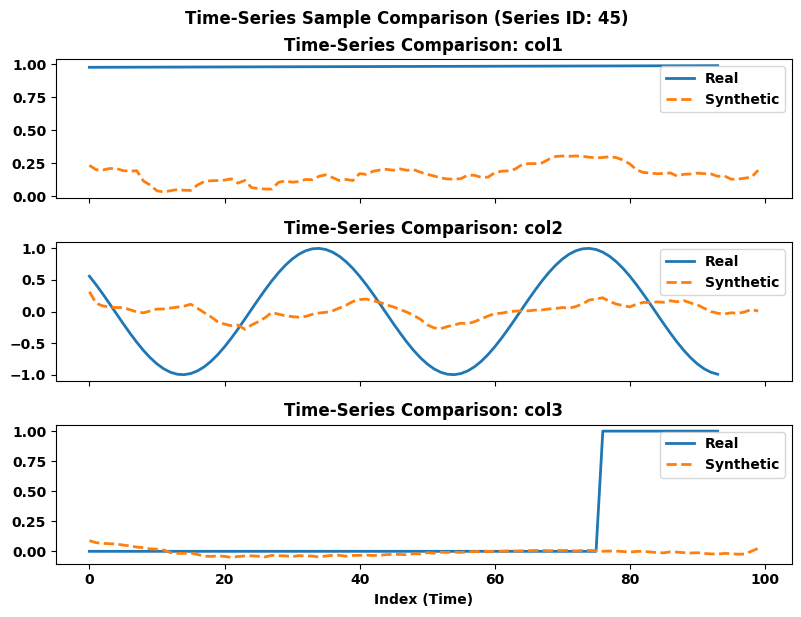

In [27]:
# QC 
# plot random
i = random.randint(0, 99)
real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
synth_path = os.path.join(synth_dir, f"sample_{i}.csv")
cols = ['col1', 'col2', 'col3']

real_sample = pd.read_csv(real_path)[cols]
synth_sample = pd.read_csv(synth_path)[cols]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 6), sharex=True)
for idx, col in enumerate(cols):
    axes[idx].plot(real_sample[col], label='Real', linewidth=2)
    axes[idx].plot(synth_sample[col], label='Synthetic', linewidth=2, linestyle='--')
    axes[idx].set_title(f'Time-Series Comparison: {col}')
    axes[idx].legend()

plt.xlabel('Index (Time)')
plt.tight_layout()
plt.suptitle(f'Time-Series Sample Comparison (Series ID: {i})', y=1.02)
plt.show()

NOTE:
- `.id` -> `id` 
- all numerical
- do not stack all data together
- static file of real and synthetic data are the same. 
- basically, comparing series_X.csv (real) vs sample_X.csv (ts1 synthetic)

### preprocessing
better to encode to ensure fixed-size, more representation capturing temporal dynamics
<br> RNN is better/more flexible for variable-length inputs. CNN would be faster for shorter fixed-length sequences.

In [28]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1):
        super(RNNEncoder, self).__init__()
        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        _, h_n = self.rnn(x)  # Only return the final hidden state
        return h_n[-1]        # Shape: (batch_size, hidden_dim)

def encode_series(df, model, device='cpu'):
    """
    Encode a single time-series DataFrame using a preloaded RNN model.
    Args:
        df (pd.DataFrame): Shape (T, D) for one time series.
        model (nn.Module): Pretrained RNN encoder.
        device (str): 'cpu' 
    Returns:
        np.ndarray: Encoded vector of shape (hidden_dim,)
    """
    model.eval()
    with torch.no_grad():
        ts_tensor = torch.tensor(df.values, dtype=torch.float32).unsqueeze(0).to(device)  # (1, T, D)
        encoding = model(ts_tensor).squeeze(0).cpu().numpy()  # (hidden_dim,)
    return encoding


In [29]:
def encode_all_pairs(real_dir, synth_dir, n=100, device='cpu'):
    real_encs, synth_encs, valid_ids = [], [], []

    # Infer input_dim from one sample
    sample_file = os.listdir(real_dir)[0]
    input_dim = pd.read_csv(os.path.join(real_dir, sample_file)).shape[1]
    # print(input_dim)
    
    model = RNNEncoder(input_dim=input_dim).to(device)
    model.eval()
    
    for i in range(n):
        # real_dir = os.path.join(data_dir, filetype, filefolder)
        # synth_dir = os.path.join(data_dir, synth_type, synth_folder)

        real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
        synth_path = os.path.join(synth_dir, f"sample_{i}.csv")

        if not os.path.exists(real_path) or not os.path.exists(synth_path):
            continue

        df_real = pd.read_csv(real_path)
        df_synth = pd.read_csv(synth_path)

        # errors if empty df
        if df_real.empty or df_synth.empty:
            continue

        real_enc = encode_series(df_real, model, device)
        synth_enc = encode_series(df_synth, model, device)

        real_encs.append(real_enc)
        synth_encs.append(synth_enc)
        valid_ids.append(i)

    return np.array(real_encs), np.array(synth_encs), valid_ids

### Fidelity metric
Fidelity examines the similarity between real and synthetic data (Ang et al., 2023)
<br> Start with C-FID, given robustness issues with Discriminative Score DS and Predictive Score PS. Its prowess in gauging fidelity based on representations bestows it with the capability to augment subsequent tasks.

#### Model-based measure - Contextual-FID (C-FID) 
**Model-based measure**
<br> An adaptation of the Fréchet Inception Distance (FID) designed specifically for evaluating the quality of synthetic time series data. 
<br> To quantify how well the synthetic time series conforms to the local context of the original time series.
<br> This means it assesses whether the synthetic data not only matches the overall distribution but also appropriately captures the sequences, patterns, and conditional relationships present in the real data

In [30]:
def frechet_distance(mu1, sigma1, mu2, sigma2):
    # covmean = sqrtm(sigma1 @ sigma2)
    covmean = sqrtm(sigma1 @ sigma2 + np.eye(sigma1.shape[0]) * 1e-6) # for numerical stability?
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    return np.sum((mu1 - mu2) ** 2) + np.trace(sigma1 + sigma2 - 2 * covmean)

def compute_cfid_per_pair(real_encs, synth_encs):
    cfid_scores = []

    for r, s in zip(real_encs, synth_encs):
        # check --> r and s are 1D vectors already (shape: (hidden_dim,))
        # mu1, mu2 = r.mean(keepdims=True), s.mean(keepdims=True) --> incorrect.
        mu1 = r
        mu2 = s
        # sigma1 = np.eye(len(r))  # assume identity since no variance across samples?
        # sigma2 = np.eye(len(s))
        sigma1 = np.cov(r.T) if r.ndim > 1 else np.eye(len(r)) # do not assume identity
        sigma2 = np.cov(s.T) if s.ndim > 1 else np.eye(len(s))

        cfid = frechet_distance(mu1, sigma1, mu2, sigma2)
        cfid_scores.append(cfid)

    return cfid_scores


In [31]:
real_dir = os.path.join(data_dir, filetype, filefolder)
synth_dir = os.path.join(data_dir, synth_type, synth_folder)

real_embs, synth_embs, valid_ids = encode_all_pairs(real_dir, synth_dir, n=100, device='cpu')

# per-pair score
cfid_scores = compute_cfid_per_pair(real_embs, synth_embs)

min_cfid_score = min(cfid_scores)
max_cfid_score = max(cfid_scores)
mean_cfid_score = sum(cfid_scores) / len(cfid_scores)
min_index = valid_ids[np.argmin(cfid_scores)]

print(f"Min C-FID: {min_cfid_score:.6f} (at i={min_index})")
print(f"Max C-FID: {max_cfid_score:.6f}")
print(f"Mean C-FID: {mean_cfid_score:.6f}")

Min C-FID: 0.008779 (at i=17)
Max C-FID: 1.067869
Mean C-FID: 0.424382


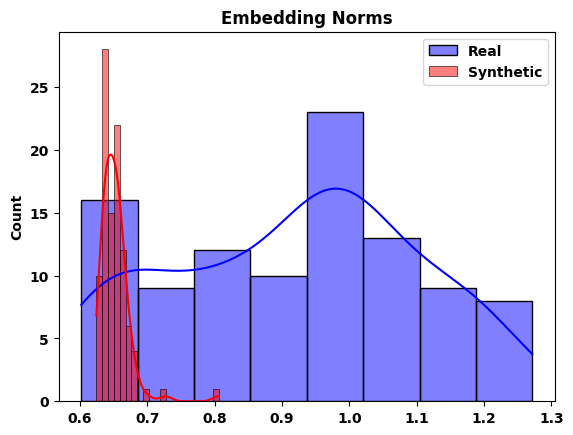

In [32]:
# QC 
# Compare embedding norms
real_norms = np.linalg.norm(real_embs, axis=1)
synth_norms = np.linalg.norm(synth_embs, axis=1)

sns.histplot(real_norms, color='blue', label='Real', kde=True)
sns.histplot(synth_norms, color='red', label='Synthetic', kde=True)
plt.legend()
plt.title("Embedding Norms")
plt.show()


In [33]:
# worse case
# randomly generated synthetic noise
def compute_cfid_single_pair(real_enc, synth_enc):
    mu1 = real_enc
    mu2 = synth_enc
    sigma1 = np.cov(real_enc.T) if real_enc.ndim > 1 else np.eye(len(real_enc))
    sigma2 = np.cov(synth_enc.T) if synth_enc.ndim > 1 else np.eye(len(synth_enc))
    return frechet_distance(mu1, sigma1, mu2, sigma2)

# random selected real data
real_dir = os.path.join(data_dir, filetype, filefolder)
i = random.randint(0, 99)
real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
real_df = pd.read_csv(real_path)
real_data = real_df.values

# just noise between [0,1]
min_vals = real_data.min(axis=0)
max_vals = real_data.max(axis=0)
noise_data = np.random.uniform(low=min_vals, high=max_vals, size=real_data.shape)

worst_cfid_score = compute_cfid_single_pair(real_data, noise_data)

print(f"Worst-case C-FID between real series_{i:03d}.csv and random noise: {worst_cfid_score:.6f}")

Worst-case C-FID between real series_091.csv and random noise: 116.430249


NOTE:
- Lower score = more similar
- real embeddings with a wider spread
- synthetic embeddings are tightly clustered
- overlap is minimal, so synthetic data might not be well aligned with real data? so should expect higher c-fid?

#### Feature-based measure

##### Skewness Difference SD

In [34]:
def skewness_diff_per_pair(real_embs, synth_embs):
    skew_diffs = []

    for i, (r, s) in enumerate(zip(real_embs, synth_embs)):
        r_skew = skew(r, axis=0)
        s_skew = skew(s, axis=0)
        diff = np.linalg.norm(r_skew - s_skew)
        skew_diffs.append(diff)

    return skew_diffs

In [35]:
skew_diffs = skewness_diff_per_pair(real_embs, synth_embs)

min_skew_diff = np.min(skew_diffs)
max_skew_diff = np.max(skew_diffs)
mean_skew_diff = np.mean(skew_diffs)
min_index = valid_ids[np.argmin(skew_diffs)]

print(f"Min Skew Diff: {min_skew_diff:.6f} (at i={min_index})")
print(f"Max Skew Diff: {max_skew_diff:.6f}")
print(f"Mean Skew Diff: {mean_skew_diff:.6f}")

Min Skew Diff: 0.002719 (at i=21)
Max Skew Diff: 0.563207
Mean Skew Diff: 0.296911


In [36]:
# worse case
def skewness_diff_single_pair(real_data, synth_data):
    r_skew = skew(real_data, axis=0)
    s_skew = skew(synth_data, axis=0)
    diff = np.linalg.norm(r_skew - s_skew)
    return diff

real_dir = os.path.join(data_dir, filetype, filefolder)

i = random.randint(0, 99)
real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
real_df = pd.read_csv(real_path)
real_data = real_df.values

min_vals = real_data.min(axis=0)
max_vals = real_data.max(axis=0)
noise_data = np.random.uniform(low=min_vals, high=max_vals, size=real_data.shape)

worst_skew_diff = skewness_diff_single_pair(real_data, noise_data)

print(f"Skewness Difference between real series_{i:03d}.csv and column-wise noise: {worst_skew_diff:.6f}")


Skewness Difference between real series_058.csv and column-wise noise: 3.293219


NOTE:
- lower SD score the better
- \> 0.3 is poor skewness? 

##### Kurtosis Difference KD

In [37]:
def kurtosis_diff_per_pair(real_embs, synth_embs):
    kurt_diffs = []

    for r, s in zip(real_embs, synth_embs):
        r_kurt = kurtosis(r, axis=0)
        s_kurt = kurtosis(s, axis=0)
        diff = np.linalg.norm(r_kurt - s_kurt)
        kurt_diffs.append(diff)

    return kurt_diffs

In [38]:
kurt_diffs = kurtosis_diff_per_pair(real_embs, synth_embs)

min_kurt_diff = np.min(kurt_diffs)
max_kurt_diff = np.max(kurt_diffs)
mean_kurt_diff = np.mean(kurt_diffs)
min_index = valid_ids[np.argmin(kurt_diffs)]

print(f"Min Kurtosis Diff: {min_kurt_diff:.6f} (at i={min_index})")
print(f"Max Kurtosis Diff: {max_kurt_diff:.6f}")
print(f"Mean Kurtosis Diff: {mean_kurt_diff:.6f}")


Min Kurtosis Diff: 0.001132 (at i=17)
Max Kurtosis Diff: 1.288083
Mean Kurtosis Diff: 0.500193


In [39]:
# worst case scenario
def kurtosis_diff_single_pair(real_data, synth_data):
    r_kurt = kurtosis(real_data, axis=0)
    s_kurt = kurtosis(synth_data, axis=0)
    diff = np.linalg.norm(r_kurt - s_kurt)
    return diff

real_dir = os.path.join(data_dir, filetype, filefolder)

i = random.randint(0, 99)
real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
real_df = pd.read_csv(real_path)
real_data = real_df.values

min_vals = real_data.min(axis=0)
max_vals = real_data.max(axis=0)
noise_data = np.random.uniform(low=min_vals, high=max_vals, size=real_data.shape)

worst_kurt_diff = kurtosis_diff_single_pair(real_data, noise_data)

print(f"Kurtosis Difference between real series_{i:03d}.csv and column-wise noise: {worst_kurt_diff:.6f}")


Kurtosis Difference between real series_018.csv and column-wise noise: 2.216634


NOTE:
- lower KD = better kurtosis
- KD \> 1 is pretty bad 

#### Distance-based measure - Dynamic Time Wrapping (DTW) 
Determines the similiarty between two sequences by considering shifts in the time dimension.
<br> The distance matrix typically uses Euclidean distance between corresponding points in the data.

In [40]:
def load_multivariate_series_pairs(real_dir, synth_dir, n=100, cols=['col1','col2','col3']):
    # assume each col is equally impt 
    real_series_list = []
    synth_series_list = []

    for i in range(n):
        real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
        synth_path = os.path.join(synth_dir, f"sample_{i}.csv")

        if not os.path.exists(real_path) or not os.path.exists(synth_path):
            continue

        df_real = pd.read_csv(real_path)
        df_synth = pd.read_csv(synth_path)

        if df_real.empty or df_synth.empty:
            continue

        real_ts = df_real[cols].values
        synth_ts = df_synth[cols].values

        real_series_list.append(real_ts)
        synth_series_list.append(synth_ts)

    return real_series_list, synth_series_list

def normalize_ts(ts):
    # dtw does not need encoding
    # best to normalise though
    scaler = StandardScaler()
    return scaler.fit_transform(ts)

def dtw_for_multivariate_pairs(real_series_list, synth_series_list):
    def multivariate_dtw(ts_real, ts_synth):
        dists = []
        for d in range(ts_real.shape[1]):
            dists.append(dtw.distance(ts_real[:, d], ts_synth[:, d]))
        return np.mean(dists)

    dtw_distances = []
    for ts_real, ts_synth in zip(real_series_list, synth_series_list):
        ts_real_norm = normalize_ts(ts_real)
        ts_synth_norm = normalize_ts(ts_synth)
        dist = multivariate_dtw(ts_real_norm, ts_synth_norm)
        dtw_distances.append(dist)

    return dtw_distances


In [41]:
# loop pairwise 
real_dir = os.path.join(data_dir, filetype, filefolder)
synth_dir = os.path.join(data_dir, synth_type, synth_folder)

real_list, synth_list = load_multivariate_series_pairs(real_dir, synth_dir, n=100)
dtw_distances = dtw_for_multivariate_pairs(real_list, synth_list)

# print("Mean DTW distance:", np.mean(dtw_distances))
valid_ids = list(range(len(dtw_distances))) 

min_dtw = min(dtw_distances)
max_dtw = max(dtw_distances)
mean_dtw = sum(dtw_distances) / len(dtw_distances)
min_index = valid_ids[np.argmin(dtw_distances)]

print(f"Min DTW: {min_dtw:.6f} (at i={min_index})")
print(f"Max DTW: {max_dtw:.6f}")
print(f"Mean DTW: {mean_dtw:.6f}")

Min DTW: 4.224942 (at i=97)
Max DTW: 12.704863
Mean DTW: 8.766106


In [42]:
# worst case scenario
def normalize_ts(ts):
    scaler = StandardScaler()
    return scaler.fit_transform(ts)

def multivariate_dtw(ts_real, ts_synth):
    dists = []
    for d in range(ts_real.shape[1]):
        dists.append(dtw.distance(ts_real[:, d], ts_synth[:, d]))
    return np.mean(dists)

real_dir = os.path.join(data_dir, filetype, filefolder)

i = random.randint(0, 99)
real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
real_df = pd.read_csv(real_path)
real_data = real_df.values

# synthetic - random noise
min_vals = real_data.min(axis=0)
max_vals = real_data.max(axis=0)
noise_data = np.random.uniform(low=min_vals, high=max_vals, size=real_data.shape)

real_norm = normalize_ts(real_data)
noise_norm = normalize_ts(noise_data)

worst_dtw_distance = multivariate_dtw(real_norm, noise_norm)

print(f"DTW distance between real series_{i:03d}.csv and noise: {worst_dtw_distance:.6f}")


DTW distance between real series_062.csv and noise: 11.150717


NOTE:
- lower DTW means that time series are more similar
- DTW works even if time series lengths differ.
- Take mean per-pair DTW is a simple way for multivariate; more advanced approaches exist though

### Diversity metric
Diversity gauges how closely the generated series distribution mirrors the original (Ang et al., 2023)
<br> How well the synthetic captures variability and originality of the real data? That is the synthesis or the generalisation metric?
<br> Did not do

#### XX

### Privacy metric

#### Nearest neighbor distance ratio NNDR
NNDR measures the ratio of each synthetic record’s distance to the nearest training neighbor compared to the distance to the second nearest training neighbor. 
Higher values indicate better privacy. Low values may reveal sensitive information from the closest real data record. A value close to 0 implies that the point is likely to be close to an outlier. 
<br> since DTW was already set up, use DTW distance to sort and compute nearest neighbours. but really slow. so forget it.
<br> given diff lengths in real/synthetic data, best option is to resample and normalise. just use nearest neighbours based on euclidean distance.

In [43]:
# def nndr_dtw(real_series_list, synth_series_list):
#     # using DTW is slow
#     nndr_values = []

#     for synth_ts in synth_series_list:
#         synth_ts_norm = normalize_ts(synth_ts)
#         distances = []

#         for real_ts in real_series_list:
#             real_ts_norm = normalize_ts(real_ts)
#             dist = np.mean([
#                 dtw.distance(synth_ts_norm[:, d], real_ts_norm[:, d])
#                 for d in range(synth_ts.shape[1])
#             ])
#             distances.append(dist)

#         sorted_dists = np.sort(distances)
#         if len(sorted_dists) >= 2:
#             d1, d2 = sorted_dists[0], sorted_dists[1]
#             nndr = d1 / d2 if d2 != 0 else np.inf
#             nndr_values.append(nndr)

#     return nndr_values


In [44]:
def resample_ts(ts, target_len):
    # 
    T, D = ts.shape
    x_old = np.linspace(0, 1, T)
    x_new = np.linspace(0, 1, target_len)
    ts_resampled = np.zeros((target_len, D))

    for d in range(D):
        interp_func = interp1d(x_old, ts[:, d], kind='linear', fill_value='extrapolate')
        ts_resampled[:, d] = interp_func(x_new)

    return ts_resampled

def nndr_nn_per_pair(real_list, synth_list, target_len=100):
    stats = []
    for i, (real_ts, synth_ts) in enumerate(zip(real_list, synth_list)):
        # resample
        real_resampled = resample_ts(real_ts, target_len)
        synth_resampled = resample_ts(synth_ts, target_len)

        scaler = StandardScaler()
        real_norm = scaler.fit_transform(real_resampled)
        synth_norm = scaler.transform(synth_resampled)

        nbrs = NearestNeighbors(n_neighbors=2).fit(real_norm)
        distances, _ = nbrs.kneighbors(synth_norm, n_neighbors=2)

        ratios = distances[:, 0] / distances[:, 1]
        mean_ratio = np.mean(ratios)
        pct5_ratio = np.percentile(ratios, 5)

        stats.append((i, mean_ratio, pct5_ratio))

    return stats

In [45]:
pairwise_stats = nndr_nn_per_pair(real_list, synth_list)

valid_ids = [s[0] for s in pairwise_stats]  
nndr_scores = [s[1] for s in pairwise_stats]      
fifth_pcts = [s[2] for s in pairwise_stats]      
      
print("NNDR Stats across all pairs:")
min_5p = min(fifth_pcts)
max_5p = max(fifth_pcts)
mean_5p = sum(fifth_pcts) / len(fifth_pcts)
max_5p_index = valid_ids[np.argmax(fifth_pcts)]

print(f"Min 5th pct NNDR: {min_5p:.6f}")
print(f"Max 5th pct NNDR: {max_5p:.6f} (at i={max_5p_index})")
print(f"Mean 5th pct NNDR: {mean_5p:.6f}")

NNDR Stats across all pairs:
Min 5th pct NNDR: 0.543691
Max 5th pct NNDR: 0.999984 (at i=58)
Mean 5th pct NNDR: 0.974594


In [46]:
# worst case scenario
real_dir = os.path.join(data_dir, filetype, filefolder)

i = random.randint(0, 99)
real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
real_df = pd.read_csv(real_path)
real_data = real_df.values

# synthetic - random noise
min_vals = real_data.min(axis=0)
max_vals = real_data.max(axis=0)
noise_data = np.random.uniform(low=min_vals, high=max_vals, size=real_data.shape)

real_resampled = resample_ts(real_data, 100)
synth_resampled = resample_ts(noise_data, 100)

scaler = StandardScaler()
real_norm = scaler.fit_transform(real_resampled)
synth_norm = scaler.transform(synth_resampled)

nbrs = NearestNeighbors(n_neighbors=2).fit(real_norm)
distances, _ = nbrs.kneighbors(synth_norm, n_neighbors=2)

ratios = distances[:, 0] / distances[:, 1]
mean_ratio = np.mean(ratios)
best_pct5_ratio = np.percentile(ratios, 5)

print(f"NNDR (5th percentile) between real series_{i:03d}.csv and noise: {best_pct5_ratio:.6f}")

NNDR (5th percentile) between real series_068.csv and noise: 0.810415


NOTE:
- Higher NNDR - better privacy
- if close to 0, indicate memorization or leakage. Too close to real data.

### Utility metric
<br> Usefulness assesses the generated series’ practical utility in predictive tasks (Ang et al., 2023)
<br> col1, col2, col3 does not really tell us what the data is used for

#### XX

### Evaluate static condition values vs metrics
Is there a way to know the performance (metrics) based on conditional values?
<br> Possible clustering or grouping of similar conditions that will lead to good performance? 

In [47]:
# merge scores with static conditions
score_df = pd.DataFrame({
    'id': list(range(len(cfid_scores))),
    'cfid': cfid_scores,
    'sd': skew_diffs,
    'kd': kurt_diffs,
    'dtw': dtw_distances,
    'nndr': fifth_pcts,
})

score_static_cond_df = pd.merge(static_real_df, score_df, on='id')

In [48]:
score_static_cond_df.head(10)

,id,b,k,w1,w2,cfid,sd,kd,dtw,nndr
0,0,0.88,-0.11,0.52,-1.29,0.85,0.53,1.06,9.71,1.00
1,1,1.31,0.69,0.23,0.28,0.90,0.49,0.48,10.68,1.00
2,2,0.32,-0.51,-1.24,-0.01,0.16,0.15,0.43,8.28,0.91
3,3,-0.24,-0.54,-1.30,-1.51,0.14,0.01,0.67,10.68,1.00
4,4,0.85,0.88,0.76,-0.39,0.50,0.42,0.08,6.97,1.00
5,5,0.28,0.37,0.08,0.66,0.09,0.13,0.44,10.14,0.84
6,6,1.08,0.98,-1.37,-0.72,0.85,0.48,0.90,6.33,1.00
7,7,-0.06,0.03,0.12,-0.07,0.27,0.25,0.61,8.78,1.00
8,8,1.41,-0.65,0.85,-0.66,1.07,0.47,0.90,10.07,1.00
9,9,0.02,-0.27,0.96,-1.52,0.37,0.25,0.76,6.23,0.99


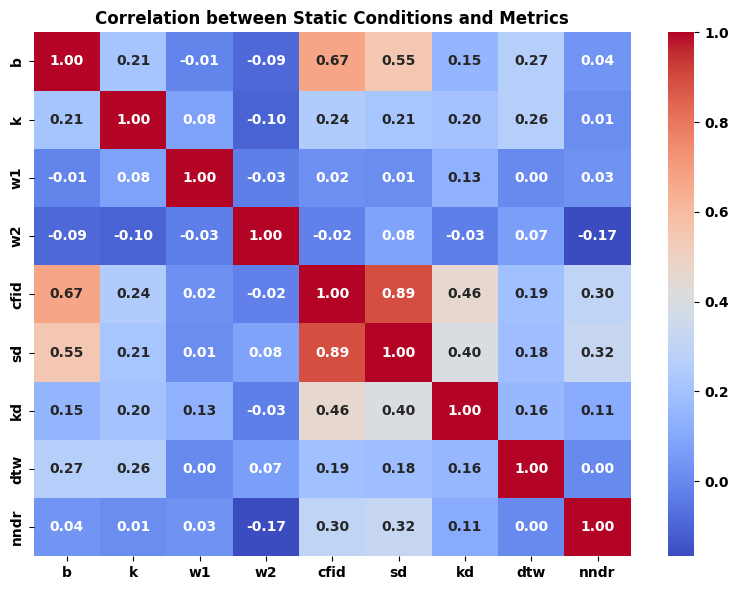

In [49]:
# find corr
corr_cols = ['b', 'k', 'w1', 'w2', 'cfid', 'sd', 'kd', 'dtw', 'nndr']
corr_matrix = score_static_cond_df[corr_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between Static Conditions and Metrics")
plt.tight_layout()
plt.show()


NOTE:
- so it seems `b` has a bigger effect on metric scores than the others?
- `w1` and `w2` have the least effect.

### Summary

,Score
Metric,
C-FID,0.42
Skewness Difference (SD),0.30
Kurtosis Difference (KD),0.50
DTW,8.77
NNDR (5th pct),0.97


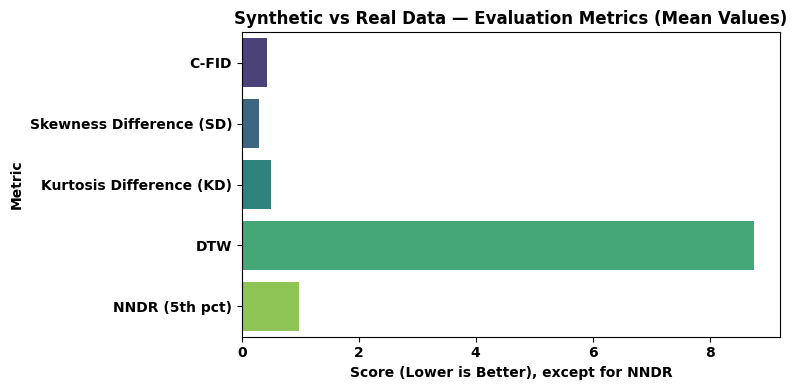

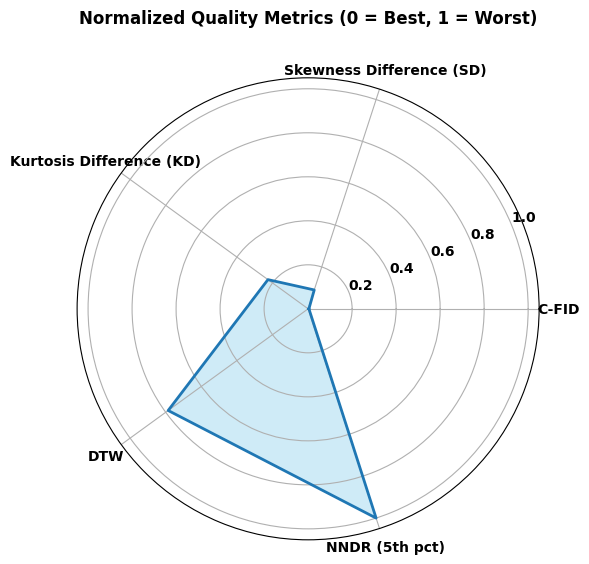

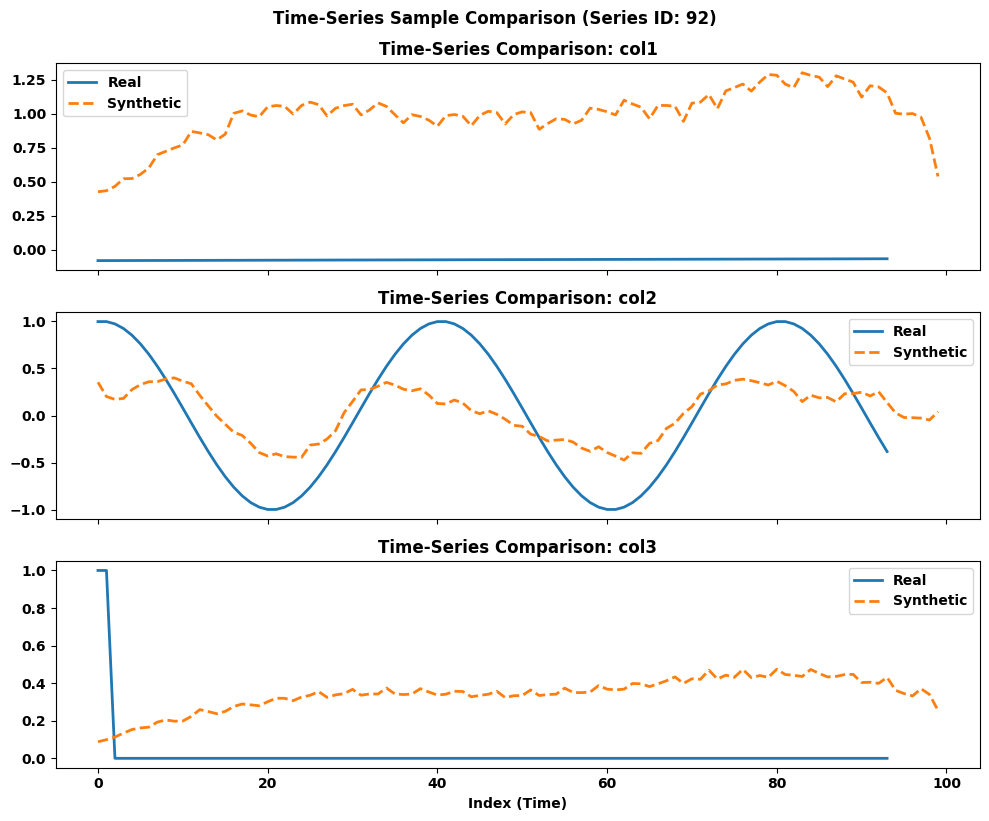

C-FID                         : 0.424 — Good
Skewness Difference (SD)      : 0.297 — Good
Kurtosis Difference (KD)      : 0.500 — Good
DTW                           : 8.766 — Needs Work
NNDR (5th pct)                : 0.975 — Needs Work


In [50]:
scores = {
    'C-FID': mean_cfid_score,  # mean
    'Skewness Difference (SD)': mean_skew_diff,
    'Kurtosis Difference (KD)': mean_kurt_diff,
    'DTW': mean_dtw,
    'NNDR (5th pct)': mean_5p,  # higher is better, so reverse
}

worst_case = {
    'C-FID': worst_cfid_score,
    'Skewness Difference (SD)': worst_skew_diff,
    'Kurtosis Difference (KD)': worst_kurt_diff,
    'DTW': worst_dtw_distance,
    'NNDR (5th pct)': 0  
}

best_case = {
    'NNDR (5th pct)': best_pct5_ratio,   # best NNDR
}

# results
df_scores = pd.DataFrame.from_dict(scores, orient='index', columns=['Score'])
df_scores.index.name = 'Metric'
display(df_scores)

# barplot
plt.figure(figsize=(8, 4))
sns.barplot(x=df_scores['Score'], y=df_scores.index, palette='viridis')
plt.title('Synthetic vs Real Data — Evaluation Metrics (Mean Values)')
plt.xlabel('Score (Lower is Better), except for NNDR')
plt.tight_layout()
plt.show()

# radar plot
def normalize_metric(score, best, worst, higher_is_better=False):
    if higher_is_better:
        norm = (score - worst) / (best - worst)
    else:
        norm = (score - best) / (worst - best)
    return min(max(norm, 0), 1)  # clip to [0, 1]

norm_scores = {
    'C-FID': normalize_metric(scores['C-FID'], best=0, worst=worst_case['C-FID']),
    'Skewness Difference (SD)': normalize_metric(scores['Skewness Difference (SD)'], best=0, worst=worst_case['Skewness Difference (SD)']),
    'Kurtosis Difference (KD)': normalize_metric(scores['Kurtosis Difference (KD)'], best=0, worst=worst_case['Kurtosis Difference (KD)']),
    'DTW': normalize_metric(scores['DTW'], best=0, worst=worst_case['DTW']),
    'NNDR (5th pct)': normalize_metric(scores['NNDR (5th pct)'], best=best_case['NNDR (5th pct)'], worst=worst_case['NNDR (5th pct)'], higher_is_better=True)
}

labels = list(norm_scores.keys())
values = list(norm_scores.values())
values += values[:1]

angles = [n / float(len(labels)) * 2 * np.pi for n in range(len(labels))]
angles += angles[:1]

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], labels)

ax.plot(angles, values, linewidth=2, linestyle='solid')
ax.fill(angles, values, 'skyblue', alpha=0.4)
plt.title("Normalized Quality Metrics (0 = Best, 1 = Worst)", y=1.1)
plt.show()

# time series comparison
i = random.randint(0, 99)
real_path = os.path.join(real_dir, f"series_{i:03d}.csv")
synth_path = os.path.join(synth_dir, f"sample_{i}.csv")
cols = ['col1', 'col2', 'col3']

real_sample = pd.read_csv(real_path)[cols]
synth_sample = pd.read_csv(synth_path)[cols]

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)
for idx, col in enumerate(cols):
    axes[idx].plot(real_sample[col], label='Real', linewidth=2)
    axes[idx].plot(synth_sample[col], label='Synthetic', linewidth=2, linestyle='--')
    axes[idx].set_title(f'Time-Series Comparison: {col}')
    axes[idx].legend()

plt.xlabel('Index (Time)')
plt.tight_layout()
plt.suptitle(f'Time-Series Sample Comparison (Series ID: {i})', y=1.02)
plt.show()

# score card summary
for metric, actual_value in scores.items():
    norm_value = norm_scores[metric]  # used only for judgment
    
    status = 'Good' if norm_value <= 0.5 else 'Needs Work'
    
    print(f"{metric:30}: {actual_value:.3f} — {status}")